# StroopActFlow
### Behavioral Analysis for Pilot Stroop subjects

#### Taku Ito
#### 02/24/17


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import os
import nibabel as nib
from sklearn.svm import SVC
import utils
glasserfile = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.RL.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'

In [2]:
def convertCSVToCIFTI64k(inputfilename,outputfilename):
    basedir = '/projects/AnalysisTools/ParcelsGlasser2016/'
    ciftitemplate = glasserfile
    wb_command = 'wb_command -cifti-convert -from-text' 
    wb_command += ' ' + inputfilename 
    wb_command += ' ' + ciftitemplate
    wb_command += ' ' + outputfilename
    wb_command += " -col-delim ','"
    wb_command += ' -reset-scalars'
    os.system(wb_command)
#     print wb_command

## 0.0 Set up

In [3]:
subjNums = ['101', '102']

basedir = '/projects3/StroopActFlow/data/'
resultsdir = basedir + 'results/'
restdir = resultsdir + 'glmRest_GlasserParcels/'

glasser_nets = np.loadtxt(basedir + 'NetworkPartitions3.1/indexsort.txt', delimiter=',')
# Make into python numbering (starts from 0)
glasser_nets -= 1.0
networkorder = glasser_nets.astype(int)
networkorder.shape = (len(networkorder),1)

networkmappings = {'fpn':6, 'vis':1, 'smn':2, 'con':3, 'dmn':8, 'aud':7, 'van':5, 'dan':4}
networks = networkmappings.keys()

networkdef = basedir + 'NetworkPartitions3.1/network_partition.txt'
networkdef = np.loadtxt(networkdef, delimiter=',')

# glasserparcels = lg.loadGlasserParcels()
# networkdef2 = lg.loadGlasserNetworks()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels
# glasserfile = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
glasser = nib.load(glasserfile).get_data()
glasser = np.squeeze(glasser)

## 1.0 Load in behavioral data

In [4]:
behavdata = {}
for subj in subjNums:
    behavdata[subj] = utils.loadBehavData(subj)

## 1.1 Overall accuracy

(0.85, 1)

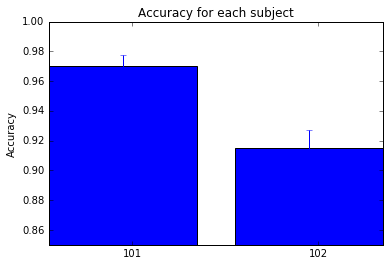

In [19]:
acc_mean = []
acc_ste = []
for subj in subjNums:
    acc_mean.append(np.mean(behavdata[subj]['accuracy']))
    acc_ste.append(np.std(behavdata[subj]['accuracy'])/np.sqrt(len(behavdata[subj]['accuracy'])))
    
plt.bar(np.arange(len(subjNums)),acc_mean,yerr=acc_ste)
plt.xticks(np.arange(len(subjNums))+.45,subjNums)
plt.title('Accuracy for each subject')
plt.ylabel('Accuracy')
plt.ylim([0.85,1])

## 1.2 RT across conditions

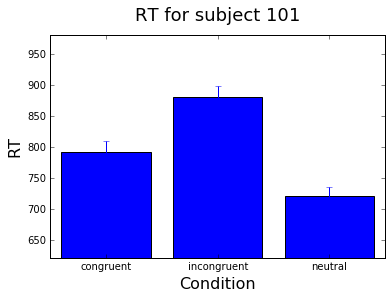

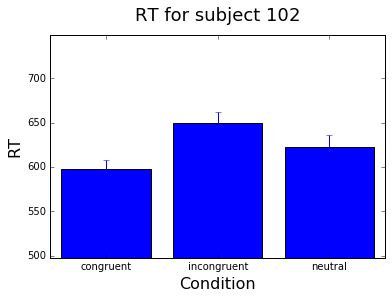

In [40]:
rt_mean = {}
rt_ste = {}
for subj in subjNums:
    rt_mean[subj] = {}
    rt_ste[subj] = {}
    congruent_ind = np.where(behavdata[subj]['condition']=='compatible')[0]
    incongruent_ind = np.where(behavdata[subj]['condition']=='incompatible')[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]
    rt_mean[subj]['congruent'] = np.mean(behavdata[subj]['rt'][congruent_ind])
    rt_ste[subj]['congruent'] = np.std(behavdata[subj]['rt'][congruent_ind])/np.sqrt(len(congruent_ind))
    rt_mean[subj]['incongruent'] = np.mean(behavdata[subj]['rt'][incongruent_ind])
    rt_ste[subj]['incongruent'] = np.std(behavdata[subj]['rt'][incongruent_ind])/np.sqrt(len(incongruent_ind))
    rt_mean[subj]['neutral'] = np.mean(behavdata[subj]['rt'][neutral_ind])
    rt_ste[subj]['neutral'] = np.std(behavdata[subj]['rt'][neutral_ind])/np.sqrt(len(neutral_ind))

    plt.figure()
    plt.bar(np.arange(len(rt_mean[subj])),rt_mean[subj].values(),yerr=rt_ste[subj].values(),align='center')
    plt.xticks(np.arange(len(rt_mean[subj])),rt_mean[subj].keys())
    plt.title('RT for subject ' + subj, fontsize=18, y=1.04)
    plt.ylabel('RT', fontsize=16)
    plt.xlabel('Condition', fontsize=16)
    plt.ylim([np.min(rt_mean[subj].values())-100, np.max(rt_mean[subj].values())+100])
    plt.savefig('RT_Conditions_'+subj+'.pdf')

## 1.3 RT Across Task rules

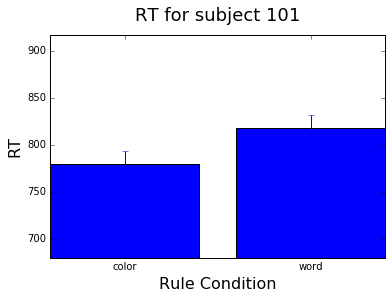

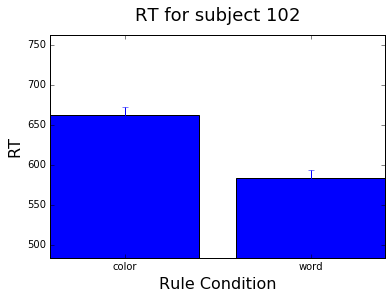

In [41]:
rt_mean = {}
rt_ste = {}
for subj in subjNums:
    rt_mean[subj] = {}
    rt_ste[subj] = {}
    color_ind = np.where(behavdata[subj]['taskRule']=='color')[0]
    word_ind = np.where(behavdata[subj]['taskRule']=='word')[0]
    rt_mean[subj]['color'] = np.mean(behavdata[subj]['rt'][color_ind])
    rt_ste[subj]['color'] = np.std(behavdata[subj]['rt'][color_ind])/np.sqrt(len(color_ind))
    rt_mean[subj]['word'] = np.mean(behavdata[subj]['rt'][word_ind])
    rt_ste[subj]['word'] = np.std(behavdata[subj]['rt'][word_ind])/np.sqrt(len(word_ind))

    plt.figure()
    plt.bar(np.arange(len(rt_mean[subj])),rt_mean[subj].values(),yerr=rt_ste[subj].values(),align='center')
    plt.xticks(np.arange(len(rt_mean[subj])),rt_mean[subj].keys())
    plt.title('RT for subject ' + subj, fontsize=18, y=1.04)
    plt.ylabel('RT', fontsize=16)
    plt.xlabel('Rule Condition', fontsize=16)
    plt.ylim([np.min(rt_mean[subj].values())-100, np.max(rt_mean[subj].values())+100])
    plt.savefig('RT_TaskRules_'+subj+'.pdf')

## 1.4 Accuracy across task conditions

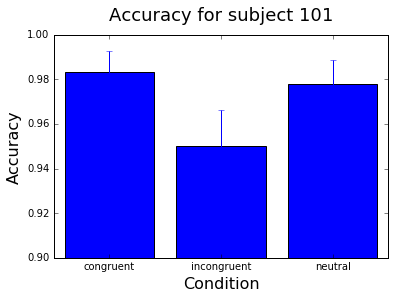

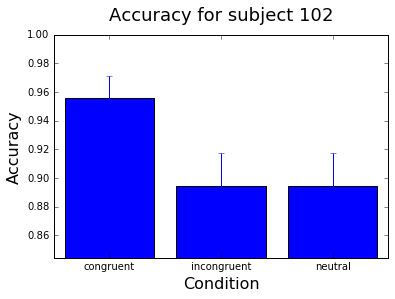

In [46]:
acc_mean = {}
acc_ste = {}
for subj in subjNums:
    acc_mean[subj] = {}
    acc_ste[subj] = {}
    congruent_ind = np.where(behavdata[subj]['condition']=='compatible')[0]
    incongruent_ind = np.where(behavdata[subj]['condition']=='incompatible')[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]
    acc_mean[subj]['congruent'] = np.mean(behavdata[subj]['accuracy'][congruent_ind])
    acc_ste[subj]['congruent'] = np.std(behavdata[subj]['accuracy'][congruent_ind])/np.sqrt(len(congruent_ind))
    acc_mean[subj]['incongruent'] = np.mean(behavdata[subj]['accuracy'][incongruent_ind])
    acc_ste[subj]['incongruent'] = np.std(behavdata[subj]['accuracy'][incongruent_ind])/np.sqrt(len(incongruent_ind))
    acc_mean[subj]['neutral'] = np.mean(behavdata[subj]['accuracy'][neutral_ind])
    acc_ste[subj]['neutral'] = np.std(behavdata[subj]['accuracy'][neutral_ind])/np.sqrt(len(neutral_ind))

    plt.figure()
    plt.bar(np.arange(len(acc_mean[subj])),acc_mean[subj].values(),yerr=acc_ste[subj].values(),align='center')
    plt.xticks(np.arange(len(acc_mean[subj])),acc_mean[subj].keys())
    plt.title('Accuracy for subject ' + subj, fontsize=18, y=1.04)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Condition', fontsize=16)
    plt.ylim([np.min(acc_mean[subj].values())-.05, 1.0])
    plt.savefig('AccuracyByConditions_'+subj+'.pdf')